In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import torch
import torch.nn as nn

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime   

from torch.utils.data import Dataset, DataLoader
from scipy import io, signal
from torchsummary import summary
import math
import random
import h5py
from tqdm import tqdm
from IPython.display import clear_output
import import_ipynb


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
class loadSimulatedDataset(Dataset):
    def __init__(self, path, split='train'):
        self.datapath = path
        self.dataCnt = 0
        self.split = split
        
        data_files = os.listdir(path)
        self.images_path = []
        self.labels = []
        for data_file in data_files:
            if data_file not in [str(i) + ".h5" for i in range(0, 100)]:   # used when the simulation is not done
                continue
            with h5py.File(path + "/" + data_file) as file:
                for group in list(file):
                    self.labels.append(np.array(file[group]['label']))
                    self.images_path.append((path + "/" + data_file, group))
                    self.dataCnt = self.dataCnt + 1
        
    def __getitem__(self, idx):
        img_path, group = self.images_path[idx]
        label = self.labels[idx]
        with h5py.File(img_path) as file:
            img = np.array(file[group]['image'])
            ret = np.zeros((2,) + img.shape)
            ret[0,:,:] = np.real(img)
            ret[1,:,:] = np.imag(img)
        
        # normalization
        ret_norm = ret / np.std(np.abs(ret))
        return torch.fft.fftshift(torch.FloatTensor(ret_norm), dim=(-1, -2)), self.labels[idx]
            
            
    def __len__(self):
        return self.dataCnt


In [4]:
batch_size = 10
initial_lr = 1e-4


train_path = "../1_multicoil/Data/h5/train2"
test_path = "../1_multicoil/Data/h5/test2"

train_ds = loadSimulatedDataset(train_path, 'train')
test_ds = loadSimulatedDataset(test_path, 'test')

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=6)


print(len(train_ds), len(test_ds))

16000 180


torch.Size([2, 224, 224]) phase-encoding line: 157


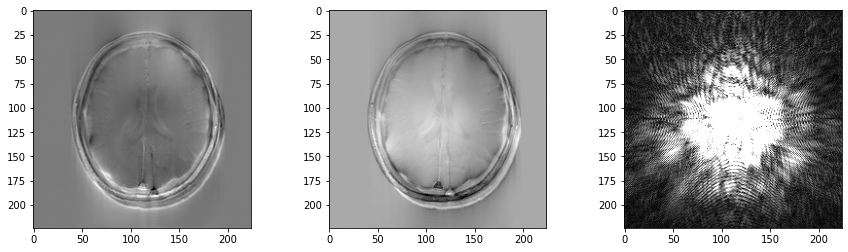

In [5]:
corrupted, pe = train_ds[23]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
ax1.imshow(np.real(np.fft.ifftn(np.fft.ifftshift(corrupted[0] + 1j * corrupted[1]), axes=(0, 1))), cmap="gray")
ax2.imshow(np.imag(np.fft.ifftn(np.fft.ifftshift(corrupted[0] + 1j * corrupted[1]), axes=(0, 1))), cmap="gray")
ax3.imshow(np.sqrt(corrupted[0]**2 + corrupted[1]**2), cmap="gray", vmin=0, vmax=1)
print(corrupted.shape, f"phase-encoding line: {pe}")

In [6]:
from torchvision.models import resnet101

# replace the first and the last layer of the resnet50 network from torchvision
model = resnet101(weights=None).to(device)
model.fc = nn.Linear(2048, 224, True).to(device)
model.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)


optimizer = optim.Adam(model.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                         mode='min',
                                         factor=0.5,
                                         patience=5, verbose=True, threshold=1e-2)

criterion = nn.CrossEntropyLoss().to(device)

In [7]:
epoch_size = 20
train_loss = []
test_acc = []
model.train()
for epoch in range(1, epoch_size+1): # 0.h5 is test set
    model.train()
    print(f"Epoch: {epoch} / {epoch_size}")
    for image, label in tqdm(train_dl):
        optimizer.zero_grad()
        input = image.to(device)
        output = model(input)
        one_hot_label = nn.functional.one_hot(label, num_classes=224).to(device)
        loss = criterion(output.to(torch.float32), one_hot_label.to(torch.float32))
        loss.backward()
        optimizer.step()
    
    clear_output()
    with torch.no_grad():
        print(f"Epoch: {epoch} / {epoch_size}\tTrain loss: {loss.item()}", end="\t")
        train_loss.append(loss.item())
        model.eval()
        correctCnt, cnt = 0, 0
        for image, label in test_dl:
            input = image.to(device)
            output = model(input)
            cnt += len(label)
            correctCnt += (torch.argmax(output, dim=1).cpu() == label).sum()
        test_acc.append(correctCnt/cnt)
        print(f"Test accuracy: {correctCnt/cnt}")
    lr_scheduler.step(1-correctCnt/cnt)

Epoch: 20 / 20	Train loss: 0.07561212033033371	Test accuracy: 0.8222222328186035


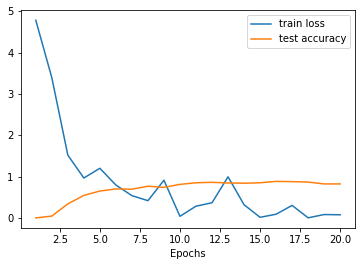

In [8]:
plt.plot(range(1, epoch_size+1), train_loss, label="train loss")
plt.plot(range(1, epoch_size+1), test_acc, label="test accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.show()

In [12]:
print(max(test_acc).item())

0.8833333253860474
